In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
xr.set_options(keep_attrs=True)
import intake
import cartopy.crs as ccrs
import cartopy as cp
from climpred.stats import dpp, varweighted_mean_period, rm_trend, rm_poly
intake.output_notebook()

In [2]:
import cdo
cdo = cdo.Cdo()

In [3]:
def _set_lon_lat_axis(ax, projection, talk=False):
    """Add longitude and latitude coordinates to cartopy plots."""
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=projection)
    ax.set_yticks([-60, -30, 0, 30, 60, 90], crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if talk:
        ax.outline_patch.set_edgecolor('black')
        ax.outline_patch.set_linewidth('1.5')
        ax.tick_params(labelsize=15)
        ax.tick_params(width=1.5)

def plot(mean, **kwargs):
    projection=ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    mean.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                       robust=True,levels=11,cbar_kwargs={'shrink':.6}, **kwargs)
    ax.set_global(); ax.coastlines();
    ax=_set_lon_lat_axis(ax, projection)
    return ax

In [25]:
savefig_kw=dict(bbox_inches='tight',dpi=200)

In [4]:
proj=ccrs.PlateCarree()

def plot2(model_obs,v,varname,products,time_op,vminmax=None,cmap='viridis',levels=21,feature='land'):
    if vminmax is not None:
        vmin,vmax=vminmax
        vmm=dict(vmin=vmin,vmax=vmax)
    else:
        vmm=dict(robust=True)
    fig,axes=plt.subplots(ncols=2,subplot_kw={'projection': proj},figsize=(15,7))
    for i,da in enumerate(model_obs):
        ax = axes[i]
        da.plot(ax=ax,transform=ccrs.PlateCarree(),
                cbar_kwargs={'shrink':.4, 'label':f'{ds.attrs["long_name"]}\n[{ds.attrs["units"]}]'}, 
                levels=levels, cmap=cmap, **vmm
               )
        ax.set_title(f'annual {time_op} {varname} {products[i]}')
        ax.set_global()
        ax.coastlines()
        if feature is not None:
            ax.add_feature(getattr(cp.feature, feature.upper()),
                                 zorder=100, edgecolor='k')
        ax=_set_lon_lat_axis(ax, proj)
        if time_op is 'std':
            plt.savefig(f'FigureSI_{v}_{time_op}_comparison.png',**savefig_kw)

In [5]:
def yearmean(ds, dim='time'):
    return ds.groupby(f'{dim}.year').mean(dim).rename({'year': dim})

In [51]:
CO2_to_C = 44.0095 / 12.0111

In [8]:
cat = intake.open_catalog('/home/mpim/m300524/pymistral/intake/obs.yml')

# ocean

### model

In [7]:
v='co2_flx_ocean'

In [8]:
#ds2 = cdo.copy(input='/work/bm1124/m300524/experiments/vga0214/outdata/echam6/vga0214_echam6_co2_mm_3000-3300.grb',returnXArray=v,
#              options='-f nc -t /work/mh0727/m300524/experiments/sample_files/log/asp_esmControl_ens3014_m004_echam6_co2.codes')
#ds2['time']=xr.cftime_range(start='3000',periods=ds2.time.size,freq='M')
#ds2=yearmean(ds2)
#ds2 = ds2 / CO2_to_C

In [10]:
ds = xr.open_dataset(f'/work/mh0727/m300524/experiments/postprocessed/control_{v}_ym.nc')[v]/CO2_to_C

In [11]:
ds.attrs['units'] = 'kg C m-2 s-1'
ds.attrs['long_name'] = 'upward surface CO$_2$ flux'

In [12]:
ocean_model_mean = ds.mean('time')
ocean_model_std = ds.std('time')

### obs SOMFFN

In [13]:
obs_ds=cat['SOMFFN'](chunks=None, xarray_kwargs={"drop_variables": ['date']}).to_dask()['fgco2']

In [14]:
#obs_ds.attrs

In [15]:
obs = -obs_ds*12/1000/(3600*24*365.25)
obs.attrs['units'] = obs_ds.attrs['units'].replace('mol','kg').replace('yr','s')

In [16]:
obs = rm_trend(yearmean(obs)) + obs.mean('time')

/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [17]:
ocean_obs_mean = obs.mean('time')
ocean_obs_std = obs.std('time')

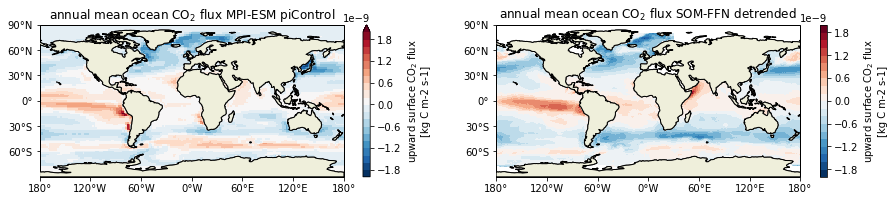

In [19]:
products = ['MPI-ESM piControl','SOM-FFN detrended']
model_obs=[ocean_model_mean,-ocean_obs_mean]

plot2(model_obs,v,"ocean CO$_2$ flux",products,time_op='mean',vminmax=[-2e-9,2e-9],cmap='RdBu_r')

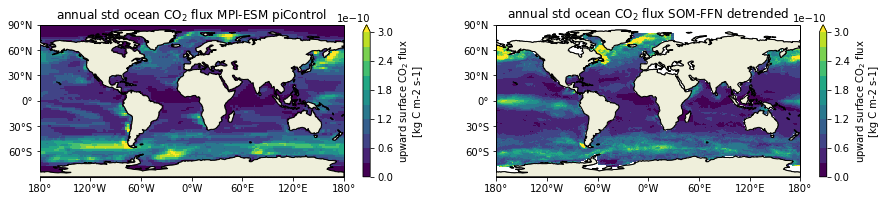

In [20]:
model_obs=[ocean_model_std, ocean_obs_std]

plot2(model_obs,v,"ocean CO$_2$ flux",products,vminmax=[0,3e-10],time_op='std',cmap='viridis',levels=11)

# land 

### model

In [52]:
v='co2_flx_land'
ds = xr.open_dataset(f'/work/mh0727/m300524/experiments/postprocessed/control_{v}_ym.nc')[v]/CO2_to_C

In [53]:
ds.attrs['units'] = 'kg C m-2 s-1'
ds.attrs['long_name'] = 'upward surface CO$_2$ flux'

In [54]:
#ds = ds - ds.rolling(time=5,center=True).mean()

In [55]:
land_model_mean = ds.mean('time')
land_model_std = ds.std('time')

### obs Jena CarboScope

In [56]:
version='s85_v4.2'
obs_ds = cat['Jena_CarboScope.atmospheric_CO2_inversion'](t_res='yearmonmean',version=version).to_dask()

In [57]:
version='sEXTocNEET_v4.3'
v='co2flux_land'
obs_ds = xr.open_dataset(f'/work/mh0727/data/Jena_CarboScope/atmospheric_CO2_inversion/{version}_daily.nc')[v].load()

In [58]:
#del obs_ds['time']
obs_ds = yearmean(obs_ds.rename({'mtime':'time'}))

In [59]:
area = cdo.gridarea(input=obs_ds.to_dataset(),returnXDataset=True)['cell_area']
#area.plot()

In [60]:
#obs_ds[v].attrs

In [61]:
obs_ds_ = obs_ds/area

In [62]:
obs = (obs_ds_)*1e12/(3600*24*365)
obs.attrs['units'] = 'kg m^-2 s^-1'

In [63]:
obs = rm_poly(obs.load(),order=2) #+ obs.mean('time')

In [64]:
land_obs_mean = obs.mean('time')
land_obs_std = obs.std('time')

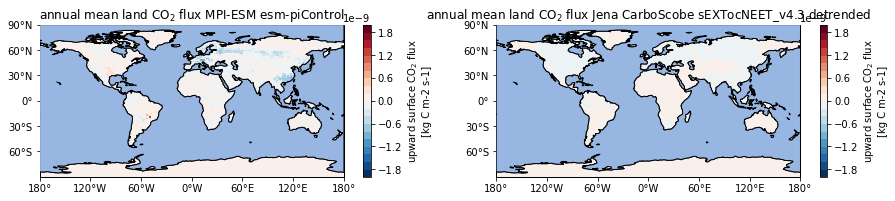

In [65]:
model_obs=[land_model_mean,land_obs_mean]
products = ['MPI-ESM esm-piControl',f'Jena CarboScobe {version} detrended']

plot2(model_obs,v,"land CO$_2$ flux",products,vminmax=[-2e-9,2e-9],time_op='mean',cmap='RdBu_r',feature='ocean')

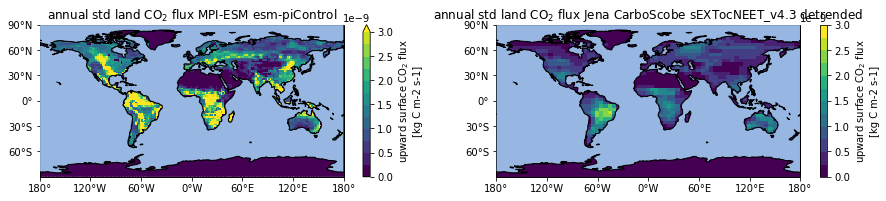

In [68]:
model_obs=[land_model_std,land_obs_std]

plot2(model_obs,v,"land CO$_2$ flux",products,vminmax=[0,3e-9],levels=13,time_op='std',cmap='viridis',feature='ocean')

# atm

### model

In [20]:
v='CO2'
ds = xr.open_dataset(f'/work/mh0727/m300524/experiments/postprocessed/control_{v}_ym.nc')[v]

In [21]:
ds.attrs['units'] = 'ppm'
ds.attrs['long_name'] = 'mixing-ratio atm. CO$_2$'

In [22]:
atm_model_mean = ds.mean('time')
atm_model_std = rm_trend(ds).std('time')

### obs

In [47]:
version='s85_v4.2'
obs_ds = cat['Jena_CarboScope.atmospheric_CO2_inversion'](t_res='yearmonmean',version=version).to_dask()

In [29]:
version='sEXTocNEET_v4.3'
obs_ds=xr.open_dataset(f'/work/mh0727/data/Jena_CarboScope/atmospheric_CO2_inversion/{version}_mix_yearmonmean.nc')

In [30]:
obs = obs_ds['co2mix'].isel(height=0)

In [31]:
atm_obs_mean = obs.mean('time')
atm_obs_std = rm_poly(obs.load(),order=2).std('time')

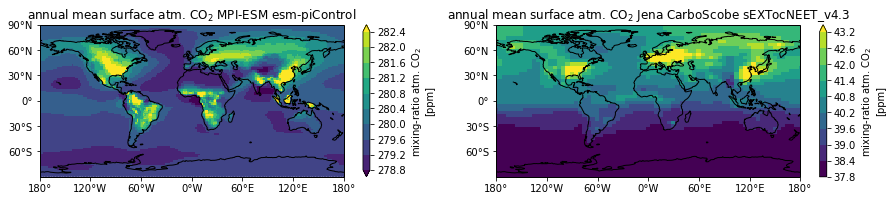

In [32]:
model_obs=[atm_model_mean,atm_obs_mean]
products = ['MPI-ESM esm-piControl',f'Jena CarboScobe {version}']

plot2(model_obs,v,"surface atm. CO$_2$",products,vminmax=None,
      time_op='mean',cmap='viridis',feature=None, levels=11)

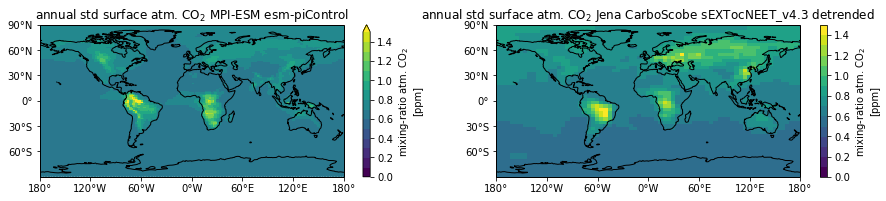

In [34]:
model_obs=[atm_model_std,atm_obs_std]
products = ['MPI-ESM esm-piControl',f'Jena CarboScobe {version} detrended']

plot2(model_obs,v,"surface atm. CO$_2$",products,vminmax=[0,1.5],
      time_op='std',cmap='viridis',feature=None, levels=16)

#### detrending order

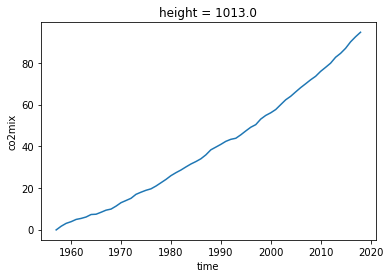

In [27]:
o=obs.mean(['lon','lat'])

o.plot()

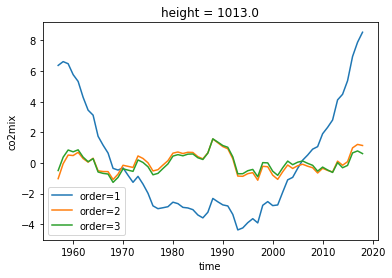

In [28]:
# use order=2 sufficient
for i in range(1,4):
    rm_poly(o,order=i).plot(label=f'order={i}')
plt.legend()

In [11]:
for v in ['co2flux_land','co2flux_ocean','co2mix']:
    for version in ["sEXTocNEET_v4.3","prior_v4.2","s76_v4.2", "s85_v4.2","s93_v4.2","s99oc_v4.3","s10oc_v4.3 ","s04oc_v4.3"]:
        try:
            obs_ds = cat['Jena_CarboScope.atmospheric_CO2_inversion'](t_res='yearmonmean',version=version).to_dask()
            d = obs_ds[v].mean(['lon','lat'])
            print(v, version, 'number of years:',d.time.size,'first',d.time.min().values,'last',d.time.max().values)
            start=int(d.time.min().values)
        except:
            print(v, version,'didnt work')
        #ds['time']=np.arange(start,start+ds.time.size)
        #ds.plot(label=f'v={version}')
    #plt.legend()
    #plt.show()

co2flux_land sEXTocNEET_v4.3 didnt work
co2flux_land prior_v4.2 number of years: 42 first 1976 last 2017
co2flux_land s76_v4.2 number of years: 42 first 1976 last 2017
co2flux_land s85_v4.2 number of years: 33 first 1985-07-01T03:00:00.000000000 last 2017-07-01T03:00:00.000000000
co2flux_land s93_v4.2 number of years: 25 first 1993 last 2017
co2flux_land s99oc_v4.3 didnt work
co2flux_land s10oc_v4.3  didnt work
co2flux_land s04oc_v4.3 didnt work
co2flux_ocean sEXTocNEET_v4.3 didnt work
co2flux_ocean prior_v4.2 number of years: 42 first 1976 last 2017
co2flux_ocean s76_v4.2 number of years: 42 first 1976 last 2017
co2flux_ocean s85_v4.2 number of years: 33 first 1985-07-01T03:00:00.000000000 last 2017-07-01T03:00:00.000000000
co2flux_ocean s93_v4.2 number of years: 25 first 1993 last 2017
co2flux_ocean s99oc_v4.3 didnt work
co2flux_ocean s10oc_v4.3  didnt work
co2flux_ocean s04oc_v4.3 didnt work
co2mix sEXTocNEET_v4.3 didnt work
co2mix prior_v4.2 didnt work
co2mix s76_v4.2 didnt work
co

In [17]:
obs_ds=xr.open_dataset('/work/mh0727/data/Jena_CarboScope/atmospheric_CO2_inversion/sEXTocNEET_v4.3_mix_yearmonmean.nc')

In [16]:
d

<xarray.DataArray 'co2mix' (time: 62, height: 19, lat: 48, lon: 72)>
[4071168 values with dtype=float32]
Coordinates:
  * height   (height) float32 1013.0 1002.87 986.8443 ... 49.8396 23.39017
  * lat      (lat) float32 -90.0 -86.17021 -82.34042 ... 82.34042 86.17021 90.0
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * time     (time) int64 1957 1958 1959 1960 1961 ... 2014 2015 2016 2017 2018